## Plotting of downstream Results for Masked Autoencoder

In [2]:
#packages
import numpy as np
import math
import time, os, random
import pickle
from tqdm import tqdm
from functools import partial
from einops import repeat, rearrange
from einops.layers.torch import Rearrange
import wandb
import h5py

import torch
import torch.nn as nn
import torchvision
#import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torchvision.transforms import ToPILImage,ToTensor, Compose, Normalize,Resize
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary


from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt


from my_utils.mae_collate import mae_collate_fn

from my_utils.mae_base import MaskedAutoencoderViT
from my_utils.mae_base3 import MaskedAutoencoderViT_ver2

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import PatchEmbed, Block
from my_utils.pos_embeds import get_2d_sincos_pos_embed

In [3]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("GPU is available.")
else:
    device = torch.device("cpu")   # Use CPU
    print("GPU is not available, using CPU.")

GPU is available.


Set up helper functions to get correct model states and predictions

In [4]:
def get_model_checkpoints(run_name):
    """
    Function that returns all the available runs with different epochs with strings .pt
    args:
    """
    print(run_name)
    model_dir = "/cluster/work/refregier/atepper/saved_models_mae/" + run_name +"/" 
    run_name_w_prefix = run_name + "_epoch_"
    suffix = ".pt"
    
    all_files = os.listdir(model_dir)
    
    #get the matching files
    model_files = [f for f in all_files if f.startswith(run_name_w_prefix) and f.endswith(suffix)] 
    
    # Sort the files by epoch number if needed
    model_files.sort(key=lambda x: int(x[len(run_name_w_prefix):-len(suffix)]))
    
    return model_files
def get_truegrid():
    truegrid_array = torch.empty((57,2))
    for i, file in tqdm(enumerate(file_paths_test), desc="Processing files"):
        with h5py.File(file, 'r') as file:
            
            #get the labels from the h5 file
            truegrid_array[i] = torch.tensor(file["labels"][0])
    return truegrid_array
#standardize
#get the statistics:
import pickle
def data_stats_dict():
    pickle_file_path = "/cluster/work/refregier/atepper/kids_450/full_data/kids450_test_stats.pkl"
    # Open the pickle file and load the data
    with open(pickle_file_path, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

def data_stats_dict():
    pickle_file_path = "/cluster/work/refregier/atepper/kids_450/full_data/kids450_test_stats.pkl"
    # Open the pickle file and load the data
    with open(pickle_file_path, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict    
def un_standardize(omega_m, sigma_8):
    
    data_dict = data_stats_dict()
    mean_labels = data_dict["mean_labels"].numpy()
    std_dev_labels = data_dict["label_std_deviation"].numpy()
    
    
    omega_m = (omega_m * std_dev_labels[0]) + mean_labels[0]
    sigma_8 = (sigma_8 * std_dev_labels[1]) + mean_labels[1]
    
    return omega_m, sigma_8

def get_predictions(model, dataloader, device='cpu'):
    #set model to eval mode
    model.eval()
    true_values_omega_m = []
    true_values_sigma_8 = []
    pred_values_omega_m = []
    pred_values_sigma_8 = []
    with torch.no_grad():  # No need to compute gradients
        for i, (images,labels_true) in tqdm(enumerate(dataloader), desc="Processing data"):
            #print(i)
            images = images.squeeze().to(device).float()
            labels_true = labels_true.squeeze().to(device).float()
            labels_pred = model(images)
            
            pred_omega_m, pred_sigma_8 = labels_pred[:, 0], labels_pred[:, 1]
            true_omega_m, true_sigma_8 = labels_true[:, 0], labels_true[:, 1]
            
            true_values_omega_m.extend(true_omega_m.cpu().numpy())
            true_values_sigma_8.extend(true_sigma_8.cpu().numpy())
            pred_values_omega_m.extend(pred_omega_m.cpu().numpy())
            pred_values_sigma_8.extend(pred_sigma_8.cpu().numpy())
            #if i == 2:
            #    print("done")
            #    break
                
    return (np.array(true_values_omega_m), np.array(pred_values_omega_m)), \
           (np.array(true_values_sigma_8), np.array(pred_values_sigma_8))


def load_checkpoint(model,run_path,run_name):
    """
    Load the model
    Returns:
    model : PreModel : model
    optimizer : torch.optim.Optimizer : optimizer
    scheduler : torch.optim.lr_scheduler : scheduler
    """
    #load_path = "/cluster/work/refregier/atepper/saved_models/" + run_name +"/" 
    #run_name = "Kids_450_regrsimclr_full_test_epoch_100.pt"
    out = os.path.join(run_path ,run_name)
    checkpoint = torch.load(out)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model
#(true_omega_m, pred_omega_m), (true_sigma_8, pred_sigma_8) = get_predictions(model, kids_test_loader, device)

In [5]:
def run_inference(model, run_name,epochs):
    true_omega_m_list = []
    true_sigma_8_list = []
    pred_omega_m_list = []
    pred_sigma_8_list = []    
    #get model checkpoints
    model_checkpoints = get_model_checkpoints(run_name)
    run_path = "/cluster/work/refregier/atepper/saved_models_mae/" + run_name +"/" 
    
    #print(model_checkpoints)
    ###########################without skip###################
    #for i,run_name in enumerate(model_checkpoints):
    #    #if i == 15:
    #    #    break
    #    #model = load_checkpoint(model, run_path ,run_name)
    #############################with skip#########################3
    #length = len(model_checkpoints)
    #print(length)
    #for i,run_name in enumerate(model_checkpoints):
    ##    if i != length-1 and i % 5 !=0 and i != 0: #definetly get first and the last, but skip every other.
    ##        continue
    #    #print(run_name)
    #    model = load_checkpoint(model, run_path ,run_name)
    #    #get predictions
    #    (true_omega_m, pred_omega_m), (true_sigma_8, pred_sigma_8) = get_predictions(model, kids_test_loader, device)
    #    #unstandardize the data
    #    unstd_pred_omega_m, unstd_pred_sigma_8 = un_standardize(pred_omega_m ,pred_sigma_8)
    #    
    #    true_omega_m_list.append(true_omega_m)
    #    pred_omega_m_list.append(unstd_pred_omega_m)
    #    true_sigma_8_list.append(true_sigma_8)
    #    pred_sigma_8_list.append(unstd_pred_sigma_8)

    #################Choose a certain model
    save_nr = 27
    #print(run_name)
    run_name = model_checkpoints[save_nr]
    model = load_checkpoint(model, run_path ,run_name)
    #get predictions
    (true_omega_m, pred_omega_m), (true_sigma_8, pred_sigma_8) = get_predictions(model, kids_test_loader, device)
    #unstandardize the data
    unstd_pred_omega_m, unstd_pred_sigma_8 = un_standardize(pred_omega_m ,pred_sigma_8)
    
    true_omega_m_list.append(true_omega_m)
    pred_omega_m_list.append(unstd_pred_omega_m)
    true_sigma_8_list.append(true_sigma_8)
    pred_sigma_8_list.append(unstd_pred_sigma_8)
    ###############################
    
    return true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list
    
def start_stop(file_nr):
    file_nr -= 1 #due to starting index of pyth
    start = file_nr *2000
    end = start + 2000
    return start, end, file_nr

In [7]:
def patchify(imgs):
    """
    Function to patchify the image into required shape
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    c = imgs.shape[1]
    p = 16
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], c, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * c))

    return x
class ViT_regresser(torch.nn.Module):
    """
    ViT regression model with multiple possible prediction heads
    """
    def __init__(self, encoder, embed_dim, head_type = "linear" ,head_dropout = 0.0, num_classes=2) -> None:
        super().__init__()
        #maybe I can cancel them here
        #for p in encoder.parameters():
        #    p.requires_grad = False
        self.head_dropout = head_dropout
        self.embed_dim = embed_dim
        self.patch_embed = encoder.patch_embed
        self.cls_token = encoder.cls_token
        self.pos_embed = encoder.pos_embed
        self.pos_drop = nn.Dropout(p=0.2)
        print(self.pos_embed.shape)
        self.patchify = patchify
        self.blocks = encoder.blocks
        self.norm = encoder.norm
        #print(self.pos_embed.shape)
        #self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)
        if head_type == 'linear':
            self.projector = torch.nn.Linear(self.pos_embed.shape[-1], num_classes)
        if head_type == 'non_linear':
            self.projector = nn.Sequential(
                torch.nn.Linear(self.pos_embed.shape[-1],128),
                #torch.nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(self.head_dropout),
                torch.nn.Linear(128,num_classes))
        
        self.global_pool = False
        if self.global_pool:
            norm_layer = nn.LayerNorm
            embed_dim = self.embed_dim
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)
            
        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
            outcome = self.projector(outcome)
            
        else:
            x = self.norm(x)
            outcome = x[:, 0]
            outcome = self.projector(outcome)
        return outcome

In [8]:
#so I have to load the pretrained model and its then initate the vit_regresser with that model
def mae_vit_base_patch8(config):
    """inputs with config file"""
    model = MaskedAutoencoderViT_ver2(
        img_size = config["img_size"], patch_size = config["patch_size"], in_chans = config["in_chans"],
        embed_dim = config["embed_dim"], depth = config["depth"], num_heads = config["num_heads"],
        decoder_embed_dim = config["decoder_embed_dim"], decoder_depth = config["decoder_depth"],
        decoder_num_heads = config["decoder_num_heads"], mlp_ratio = config["mlp_ratio"],
        norm_layer = partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

##config file for model setup
config = {
    "seed" : 62,
    "batch_size" : 1024,#4096,
    "max_device_batch_size" : 512,#512,
    "mask_ratio" : 0.5,
    "base_learning_rate": 1e-4,
    "weight_decay" : 0.01,#0.05
    "total_epoch" : 500,
    "warmup_epoch" : 10,
    "run_name" : "mae_non_linear_probe",
    "img_size" : 224,
    "patch_size": 16,
    "in_chans" : 4,
    "embed_dim" : 256,
    "depth" : 12,
    "num_heads" : 4,
    "decoder_embed_dim" : 256,
    "decoder_depth" : 4,
    "decoder_num_heads" : 4,
    "mlp_ratio" : 4.,
    "save_every" : 5,
    "norm_pix_loss" : False,
    "head_type" : "non_linear",
    "head_dropout" : 0.3,
    "training_type" : "vit_scratch",
    "pretrain_run_name" : "mae_base_224_normed_sml_model_mae2",
    "pretrain_checkpoint" : 230, #if continue, be sure to change this
    "continue_previous_train" : False,
    "last_epoch" : 0,
    }#

kwargs = {
    "proj_drop" : 0.2,
    "attn_drop" : 0.2,

}

In [9]:
###setup dataloaders
from my_utils.mae_dataloader_lin_probe import  kids450_files_cluster, mae_kids450
batch_size = 512
resolution = 224
file_paths_train, file_paths_test = kids450_files_cluster()

train_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
valid_data = mae_kids450(phase = "val",file_paths = file_paths_train,resolution = resolution)
test_data = mae_kids450(phase = "test",file_paths = file_paths_train,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 19)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 19)
kids_test_loader = DataLoader(test_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 19)

/cluster/home/atepper/thesis_env_ubuntu/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [11]:
#pretrained model
model = mae_vit_base_patch8(config).to(device)
#take the encoder
encoder = model.encoder
#setup the regression model
model = ViT_regresser(encoder,config["embed_dim"],head_type = config["head_type"], head_dropout = config["head_dropout"]).to(device)
model

torch.Size([1, 197, 256])


ViT_regresser(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(4, 256, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.2, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.2, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.2, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1024, out_fea

Look at the saved run files

In [12]:
#print the checkpoints
def get_model_checkpoints(run_name):
    """
    Function that returns all the available runs with different epochs with strings .pt
    args:
    """
    print(run_name)
    model_dir = "/cluster/work/refregier/atepper/saved_models_mae/" + run_name +"/" 
    run_name_w_prefix = run_name + "_epoch_"
    suffix = ".pt"
    
    all_files = os.listdir(model_dir)
    
    #get the matching files
    model_files = [f for f in all_files if f.startswith(run_name_w_prefix) and f.endswith(suffix)] 
    
    # Sort the files by epoch number if needed
    model_files.sort(key=lambda x: int(x[len(run_name_w_prefix):-len(suffix)]))
    
    return model_files
get_model_checkpoints("mae_non_linear_probe")

mae_non_linear_probe


['mae_non_linear_probe_epoch_0.pt',
 'mae_non_linear_probe_epoch_1.pt',
 'mae_non_linear_probe_epoch_5.pt',
 'mae_non_linear_probe_epoch_10.pt',
 'mae_non_linear_probe_epoch_15.pt',
 'mae_non_linear_probe_epoch_20.pt',
 'mae_non_linear_probe_epoch_25.pt',
 'mae_non_linear_probe_epoch_30.pt',
 'mae_non_linear_probe_epoch_35.pt',
 'mae_non_linear_probe_epoch_40.pt',
 'mae_non_linear_probe_epoch_45.pt',
 'mae_non_linear_probe_epoch_50.pt',
 'mae_non_linear_probe_epoch_55.pt',
 'mae_non_linear_probe_epoch_60.pt',
 'mae_non_linear_probe_epoch_65.pt',
 'mae_non_linear_probe_epoch_70.pt',
 'mae_non_linear_probe_epoch_75.pt',
 'mae_non_linear_probe_epoch_80.pt',
 'mae_non_linear_probe_epoch_85.pt',
 'mae_non_linear_probe_epoch_90.pt',
 'mae_non_linear_probe_epoch_95.pt',
 'mae_non_linear_probe_epoch_100.pt',
 'mae_non_linear_probe_epoch_105.pt',
 'mae_non_linear_probe_epoch_110.pt',
 'mae_non_linear_probe_epoch_115.pt',
 'mae_non_linear_probe_epoch_120.pt',
 'mae_non_linear_probe_epoch_125.pt'

In [13]:
#https://wandb.ai/atepper/new_masked_auto_linprobe/runs/uulh6s21?nw=nwuseraaditep
start_epoch = 1
end_epoch = 150
run_name = "mae_non_linear_probe"
epochs = list(range(start_epoch,end_epoch+1))
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

mae_non_linear_probe


/scratch/tmp.13165119.atepper/ipykernel_537404/572185383.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(out)
Processing data: 222it [01:21,  2.

2000 4000


Processing files: 57it [00:00, 552.08it/s]


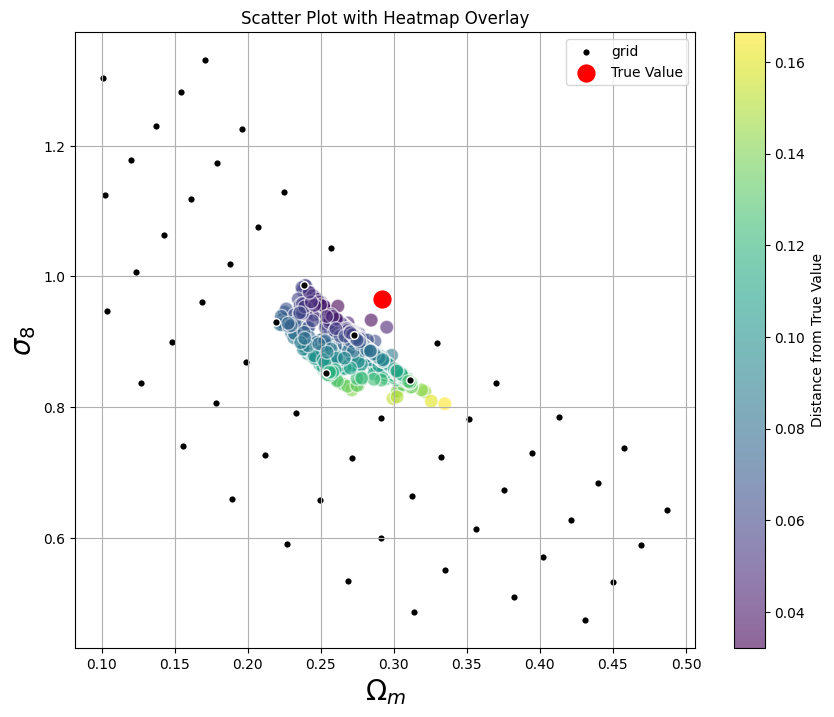

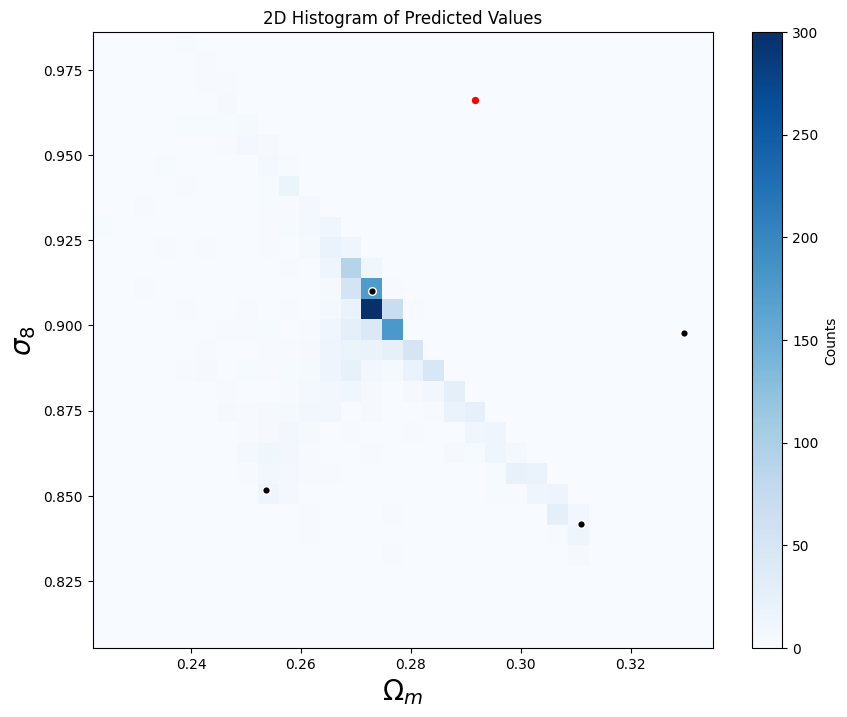

In [16]:
epoch = 0
#start = 0
#stop = 2000
start, stop, file_index = start_stop(file_nr = 2)
print(start,stop)
pred_omega_m = pred_omega_m_list[epoch][start:stop]
pred_sigma_8 = pred_sigma_8_list[epoch][start:stop]
true_omega_m = true_omega_m_list[epoch][start:stop][0]
#print(true_omega_m_list[epoch])
true_sigma_8 = true_sigma_8_list[epoch][start:stop][0]

distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pred_omega_m, pred_sigma_8, c=distances, cmap='viridis', s=100, alpha=0.6, edgecolor='w')

# Add color bar to show the distance scale
cbar = plt.colorbar(scatter)
cbar.set_label('Distance from True Value')

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Plot the true value point
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=200, label='True Value', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 
#plt.xlim(0.05, 0.5)  # Adjust the limits according to your data
#plt.ylim(0.4, 1.4) 
plt.title('Scatter Plot with Heatmap Overlay')
plt.legend()
plt.grid(True)



# Show the plot
plt.show()

# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[30, 30], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')
#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

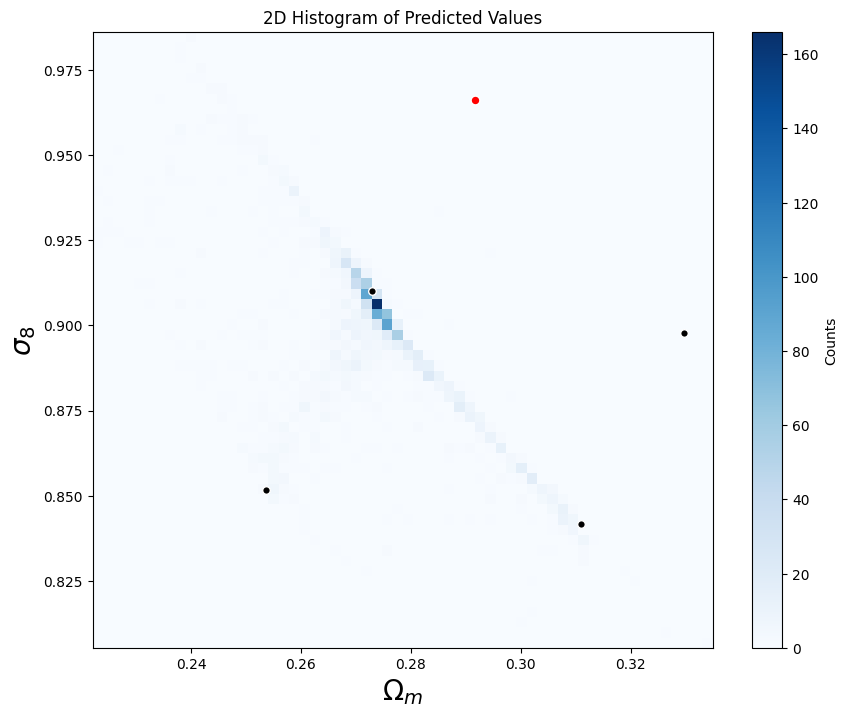

In [17]:
# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.cla()
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')

plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')


# Show plot
plt.show()

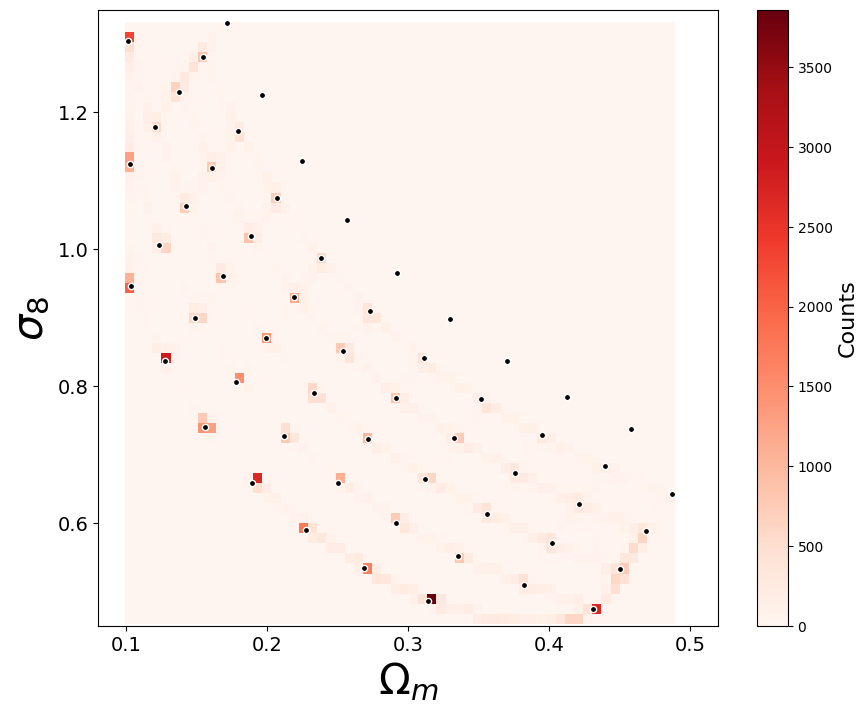

In [18]:
from matplotlib.ticker import MaxNLocator
# Create 2D histogram
x = pred_omega_m_list[epoch]
y = pred_sigma_8_list[epoch]
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[60, 60], cmap='Reds') #cmap = BLues

# Add color bar to show scale
cbar = plt.colorbar(label='Counts')
cbar.set_label("Counts" ,fontsize = 16)
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=20, label='grid', edgecolor='w')

# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 30)
plt.ylabel(r'$\sigma_8$',fontsize = 30)

# Limit the number of ticks on both axes
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(MaxNLocator(5))  # 5 ticks on the x-axis
ax.yaxis.set_major_locator(MaxNLocator(5))  # 5 ticks on the y-axis

# Set the font size for the ticks
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' means apply to both x and y axes, 'major' applies to major ticks

# Fix the x-axis limits
plt.xlim(0.08, 0.520)  # This sets the x-axis to range from 0 to 6
plt.ylim(0.45, 1.35)  # This sets the y-axis to range from 0 to 50



#plt.title('2D Histogram of Predicted Values',fontsize = 20)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/MAE/data/final_plots_simclr_pres/" +run_name+"_paramsphist"


plt.savefig(save_path+'.pdf')
plt.savefig(save_path+'.png', dpi=300)

# Show plot
plt.show()

Processing files: 57it [00:00, 617.95it/s]


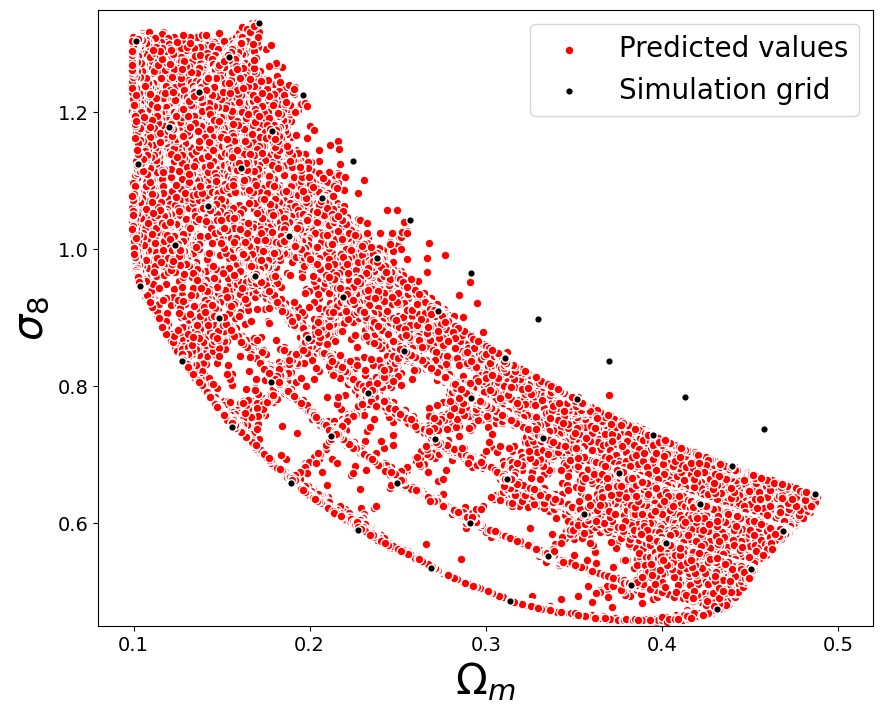

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.animation as animation
import seaborn as sns


#in the test data every parameter is concurrent 2000 elements
#epoch = 1
pred_omega_m = pred_omega_m_list[epoch]
pred_sigma_8 = pred_sigma_8_list[epoch]


plt.figure(figsize=(10, 8))


truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Add color bar to show scale #blue = "#4169E1"
plt.scatter(pred_omega_m, pred_sigma_8, c= "red", s=40, label='Predicted values',edgecolor= "w")
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='Simulation grid', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 30)
plt.ylabel(r'$\sigma_8$',fontsize = 30)

# Limit the number of ticks on both axes
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(MaxNLocator(5))  # 5 ticks on the x-axis
ax.yaxis.set_major_locator(MaxNLocator(5))  # 5 ticks on the y-axis

# Set the font size for the ticks
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' means apply to both x and y axes, 'major' applies to major ticks

# Fix the x-axis limits
plt.xlim(0.08, 0.520)  # This sets the x-axis to range from 0 to 6
plt.ylim(0.45, 1.35)  # This sets the y-axis to range from 0 to 50
plt.legend(fontsize=20)



#plt.title('Predicted Values snapshot',fontsize = 20)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/MAE/data/final_plots_simclr_pres/" +run_name+"_scatter"
plt.savefig(save_path+'.png', dpi=300)
#plt.savefig(save_path+'.pdf')

# Show plot
plt.show()

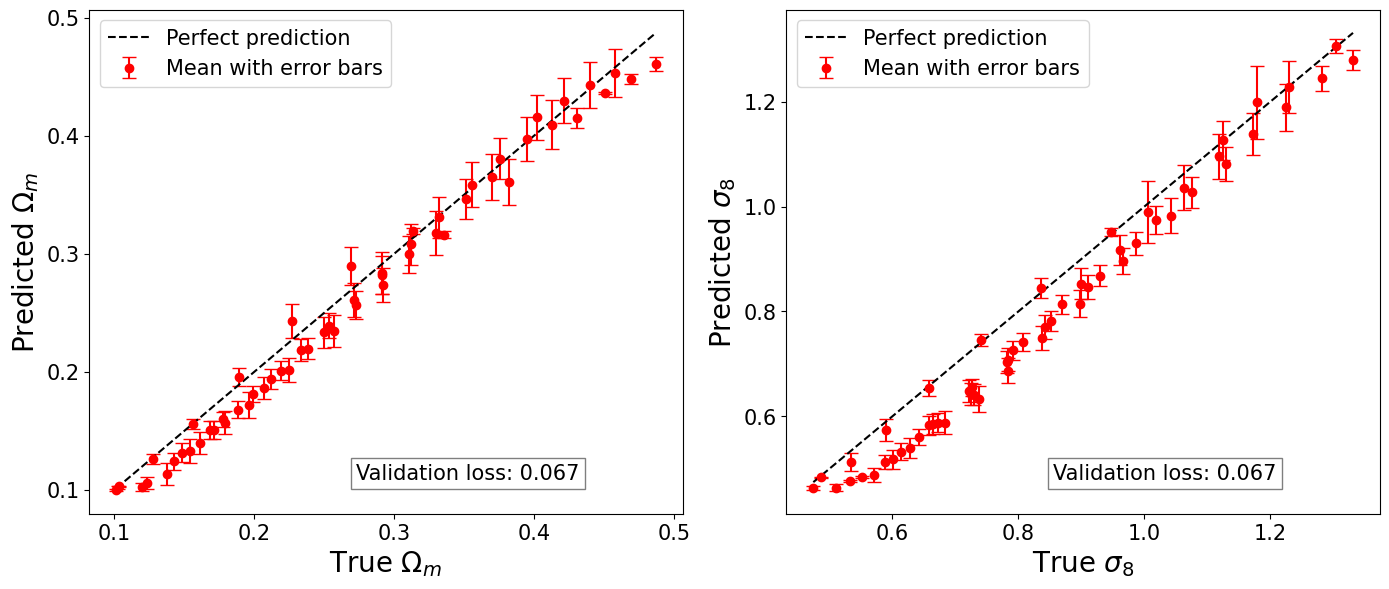

In [20]:
#### import numpy as np
import matplotlib.pyplot as plt

# Generate random data for demonstration
np.random.seed(42)
true_omega_m_list_plot = true_omega_m_list[epoch]
pred_omega_m_list_plot = pred_omega_m_list[epoch]

true_sigma_8_list_plot = true_sigma_8_list[epoch]
pred_sigma_8_list_plot = pred_sigma_8_list[epoch]

# Function to plot true vs predicted values with error bars
def plot_with_error_bars(true_values, pred_values, parameter_name, ax):
    # Calculate unique true values, their mean predicted values, and standard deviation
    unique_true_values = np.unique(true_values)
    mean_pred_values = [np.mean(pred_values[true_values == val]) for val in unique_true_values]
    std_pred_values = [np.std(pred_values[true_values == val]) for val in unique_true_values]
    
    # Scatter plot of the true vs predicted values
    #ax.scatter(true_values, pred_values, label='Data points', alpha=0.6)
    
    # Plotting the mean with error bars blue = "#4169E1"
    ax.errorbar(unique_true_values, mean_pred_values, yerr=std_pred_values, fmt='o', color="red", label='Mean with error bars', capsize=5)

    # Diagonal line (perfect prediction)
    ax.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', label='Perfect prediction')

    
    ax.set_xlabel(f'True {parameter_name}',fontsize = 20)
    ax.set_ylabel(f'Predicted {parameter_name}',fontsize = 20)

    # Set tick spacing and font size
    tick_fontsize = 15
    max_ticks = 5
    ax.xaxis.set_major_locator(MaxNLocator(max_ticks))  # Integer ticks on x-axis
    ax.yaxis.set_major_locator(MaxNLocator(max_ticks))  # Integer ticks on y-axis
    ax.xaxis.set_tick_params(labelsize=tick_fontsize)
    ax.yaxis.set_tick_params(labelsize=tick_fontsize)

    validation_loss = 0.067
    ax.text(0.45, 0.1, f'Validation loss: {validation_loss:.3f}', 
                transform=ax.transAxes, fontsize=15, verticalalignment='top', 
                bbox=dict(facecolor='white', alpha=0.5))
    
    #ax.set_title(f'True vs Predicted {parameter_name}')
    ax.legend(fontsize=15)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for omega_m
plot_with_error_bars(true_omega_m_list_plot, pred_omega_m_list_plot, '$\Omega_m$', axs[0])

# Plot for sigma_8
plot_with_error_bars(true_sigma_8_list_plot, pred_sigma_8_list_plot, '$\sigma_8$', axs[1])
#plt.title('Predicted Values snapshot',fontsize = 20)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/MAE/data/final_plots_simclr_pres/" +run_name+"_predictedtrue"

plt.savefig(save_path+'.pdf')
plt.savefig(save_path+'.png', dpi=300)

plt.tight_layout()
plt.show()

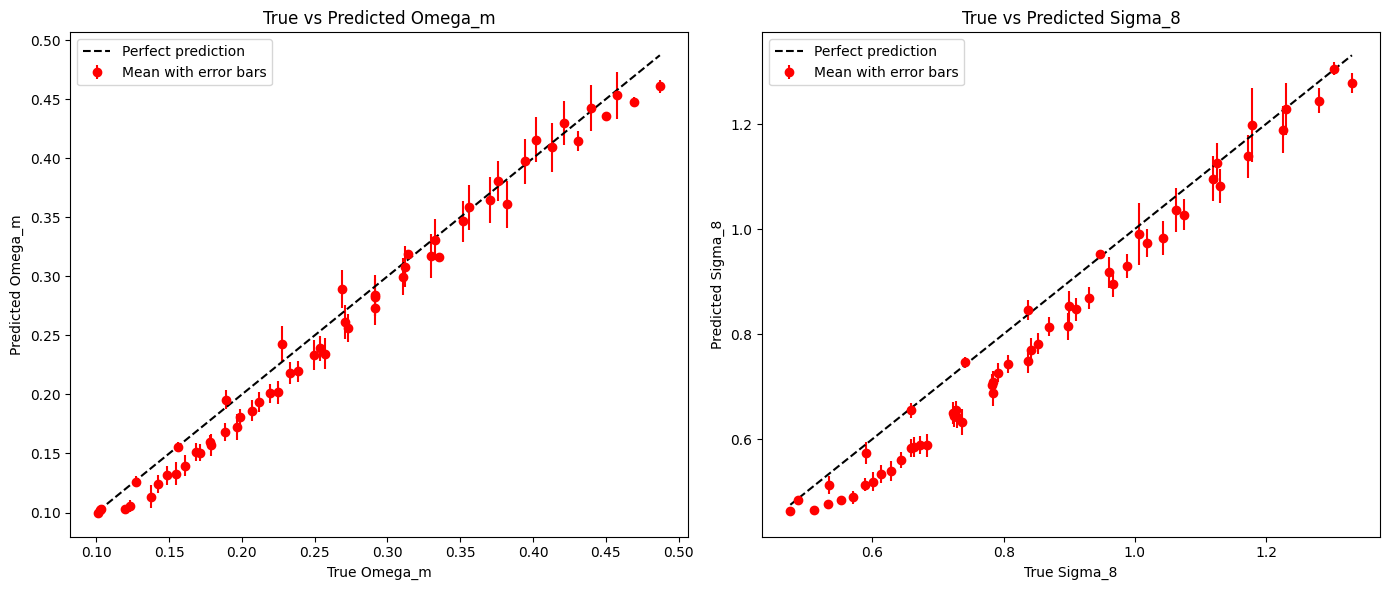

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data for demonstration
np.random.seed(42)
true_omega_m_list_plot = true_omega_m_list[0]
pred_omega_m_list_plot = pred_omega_m_list[0]

true_sigma_8_list_plot = true_sigma_8_list[0]
pred_sigma_8_list_plot = pred_sigma_8_list[0]

# Function to plot true vs predicted values with error bars
def plot_with_error_bars(true_values, pred_values, parameter_name, ax):
    # Calculate unique true values, their mean predicted values, and standard deviation
    unique_true_values = np.unique(true_values)
    mean_pred_values = [np.mean(pred_values[true_values == val]) for val in unique_true_values]
    std_pred_values = [np.std(pred_values[true_values == val]) for val in unique_true_values]

    # Scatter plot of the true vs predicted values
    #ax.scatter(true_values, pred_values, label='Data points', alpha=0.6)
    
    # Plotting the mean with error bars
    ax.errorbar(unique_true_values, mean_pred_values, yerr=std_pred_values, fmt='o', color='red', label='Mean with error bars')

    # Diagonal line (perfect prediction)
    ax.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', label='Perfect prediction')

    ax.set_xlabel(f'True {parameter_name}')
    ax.set_ylabel(f'Predicted {parameter_name}')
    ax.set_title(f'True vs Predicted {parameter_name}')
    ax.legend()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for omega_m
plot_with_error_bars(true_omega_m_list_plot, pred_omega_m_list_plot, 'Omega_m', axs[0])

# Plot for sigma_8
plot_with_error_bars(true_sigma_8_list_plot, pred_sigma_8_list_plot, 'Sigma_8', axs[1])

plt.tight_layout()
plt.show()


## Misc and Extra plots

In [23]:
#look at the prediction space

file_paths_train, file_paths_test = kids450_files_cluster()
def get_truegrid():
    truegrid_array = torch.empty((57,2))
    for i, file in tqdm(enumerate(file_paths_test), desc="Processing files"):
        with h5py.File(file, 'r') as file:
            
            #get the labels from the h5 file
            truegrid_array[i] = torch.tensor(file["labels"][0])
    return truegrid_array
true_grid = get_truegrid()

Processing files: 57it [00:05, 10.94it/s]


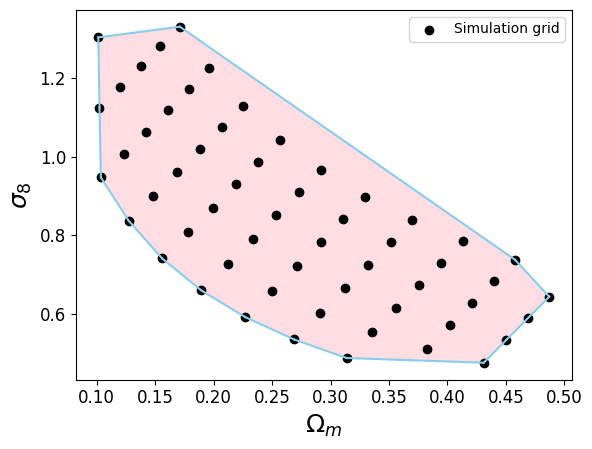

In [24]:
import torch
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Example tensor with shape [57, 2]
grid = true_grid

# Convert the tensor to a numpy array for plotting
points = grid.numpy()

# Create the scatter plot
#plt.scatter(points[:, 0], points[:, 1], color='blue', label='Points')

# Calculate the convex hull
hull = ConvexHull(points)

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], "#87CEEB")

# Fill the convex hull with light pink hue
plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], '#FF91A4', alpha=0.3)
# Create the scatter plot
plt.scatter(points[:, 0], points[:, 1], color="black", label='Simulation grid')

# Add labels and title (optional)
plt.xlabel('$\Omega_m$', fontsize=18)
plt.ylabel('$\sigma_8$', fontsize=18)
#plt.title('Cosmological Parameters with Convex Hull')
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=12)  # Set major tick label size
plt.tick_params(axis='both', which='minor', labelsize=12)  # Set minor tick label size (optional)

# Save the figure as both PDF and PNG
plt.savefig("sim_grid.pdf")
plt.savefig("sim_grid.png")
# Display the plot
plt.show()

In [26]:
def get_first_10_images_by_file_number(dataloader, file_number, images_per_file=2000):
    """
    Get the first 10 images and labels from the batch corresponding to a specific file number using the next operator.
    
    Args:
    - dataloader: PyTorch DataLoader object.
    - file_number: The file number (index) to retrieve (starts from 0).
    - images_per_file: Number of images per file (default is 2000).
    
    Returns:
    - images: Tensor containing the first 10 images.
    - labels: Tensor containing the corresponding labels.
    """
    # Calculate how many batches we need to skip to get to the desired file
    batches_to_skip = file_number * (images_per_file // dataloader.batch_size)
    
    # Create an iterator over the dataloader
    dataloader_iter = iter(dataloader)
    
    # Skip the batches that we don't need
    for _ in range(batches_to_skip):
        next(dataloader_iter)
    
    # Get the next batch after the skip
    batch_images, batch_labels = next(dataloader_iter)
    
    # Return only the first 10 images and labels from this batch
    return batch_images[:10], batch_labels[:10]

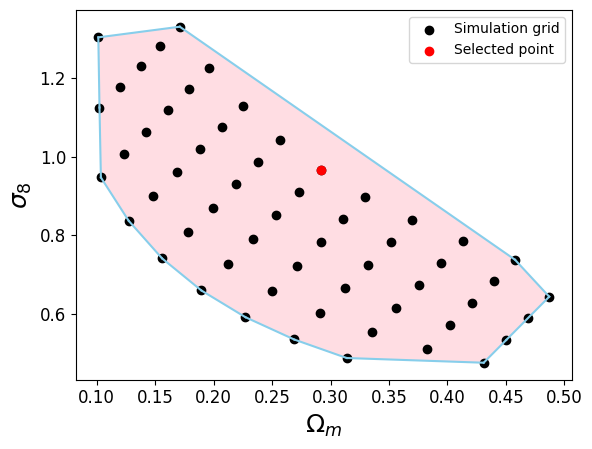

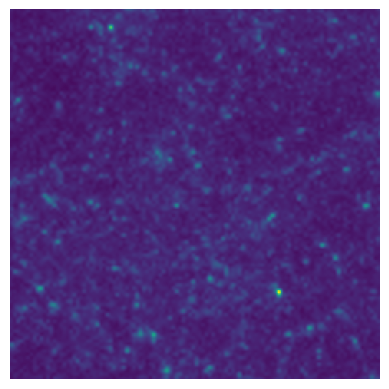

 Mean of all 4 channels: tensor([-0.0356, -0.0470, -0.0439, -0.0379])


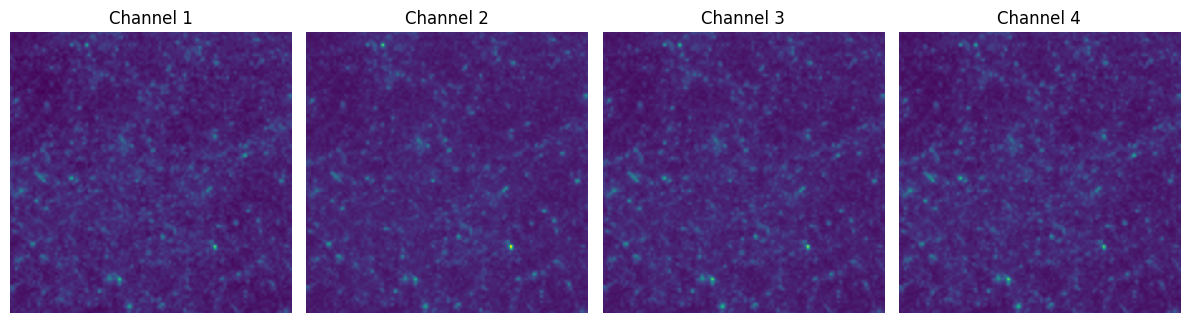

In [27]:
#Look at correspon
import torch
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

kids_test_loader = DataLoader(test_data,batch_size = 2000 , drop_last=True,collate_fn = mae_collate_fn, num_workers = 19)
images,labels = get_first_10_images_by_file_number(kids_test_loader, file_number = 1, images_per_file=2000)
img_nr = 7

vmin = images[img_nr].min()
vmax = images[img_nr].max()
# Example tensor with shape [57, 2]
grid = true_grid

# Convert the tensor to a numpy array for plotting
points = grid.numpy()

# Create the scatter plot
#plt.scatter(points[:, 0], points[:, 1], color='blue', label='Points')

# Calculate the convex hull
hull = ConvexHull(points)

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], "#87CEEB")

# Fill the convex hull with light pink hue
plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], '#FF91A4', alpha=0.3)
# Create the scatter plot
plt.scatter(points[:, 0], points[:, 1], color="black", label='Simulation grid')
plt.scatter(labels[img_nr][0], labels[img_nr][1], color="Red", label='Selected point')

# Add labels and title (optional)
plt.xlabel('$\Omega_m$', fontsize=18)
plt.ylabel('$\sigma_8$', fontsize=18)
#plt.title('Cosmological Parameters with Convex Hull')
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=12)  # Set major tick label size
plt.tick_params(axis='both', which='minor', labelsize=12)  # Set minor tick label size (optional)

# Save the figure as both PDF and PNG
plt.savefig("sim_grid.pdf")
plt.savefig("sim_grid.png")
# Display the plot
plt.show()
image_1_chan= images[img_nr][1,:, :]
plt.imshow(image_1_chan,vmin = vmin, vmax = vmax, cmap='viridis')  # Use cmap='gray' for grayscale display
#plt.title('Red Channel')


plt.axis('off')
#save_path = "/cluster/home/atepper/master_thesis/master_thesis/MAE/data/final_plots/" +"1channel_exmaple"
#plt.savefig(save_path+'.png', dpi=300)
plt.show()

image_4_chan = images[img_nr]
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
print(f' Mean of all 4 channels: {image_4_chan.mean(dim = (1,2))}')
for i in range(4):
    axs[i].imshow(image_4_chan[i,:, :],vmin = vmin, vmax = vmax, cmap='viridis')  # Assuming grayscale images, change cmap as needed
    axs[i].axis('off')
    axs[i].set_title(f'Channel {i+1}')
    
    

plt.tight_layout()

#save_path = "/cluster/home/atepper/master_thesis/master_thesis/MAE/data/final_plots/" +"4channel_exmaple"
#plt.savefig(save_path+'.png', dpi=300)

plt.show()